In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define ODEs
def VanDerPol(y, t, epsilon):
    x, y = y
    #dxdt = y
    #dydt = epsilon * (1 - x**2) * y - x
    dxdt = y - (1/3) * x**3 + x
    dydt = -epsilon * x
    return [dxdt, dydt]

In [3]:
'''
y0 = [0.002, 0.0]
t = np.linspace(0, 120, 100)  
epsilon = -0.1 
'''
y0 = [2, 0]
t = np.linspace(0, 20, 100)  
#epsilon = 0.01
epsilon = 2

In [4]:
# solve ODEs
x_real, y_real = odeint(VanDerPol, y0, t, args=(epsilon,)).T
# tranform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

In [5]:
'''
def input_transform(t_tensor):
    sin_cos_features = [torch.sin(n * t_tensor) for n in range(1, 3)] + \
                       [torch.cos(n * t_tensor) for n in range(1, 3)] + \
                       [-torch.sin(n * t_tensor) for n in range(1, 3)] 
    return torch.cat([t_tensor] + sin_cos_features, dim=1)
'''
def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

In [6]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, t):
        t = input_transform(t)  
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def loss_func(model, t_tensor, x_real, y_real, x0, y0, epsilon, random_points=10):
    
    t_tensor.requires_grad = True
    pred = model(t_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    #residual1 = dx_dt - y_pred
    #residual2 = dy_dt - (epsilon *(1 - x_pred**2) * y_pred - x_pred)
    residual1 = dx_dt - y_pred + (1/3) * x_pred**3 - x_pred
    residual2 = dy_dt + epsilon * x_pred
    
    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)
    #data_loss = torch.mean((pred_x - x_real)**2 + (pred_y - y_real)**2)
    random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 + 
                           (y_pred[random_indices] - y_real[random_indices])**2)
    
    #adjust weights
    total_loss = physics_loss + 0.01*init_loss + 10*data_loss
    #total_loss = data_loss
    return total_loss

Epoch 0, Loss: 66.7759017944336
Epoch 5000, Loss: 27.251832962036133
Epoch 10000, Loss: 6.835209369659424
Epoch 15000, Loss: 1.0016785860061646
Epoch 20000, Loss: 0.44317686557769775
Epoch 25000, Loss: 0.7385473251342773
Epoch 30000, Loss: 0.05795331299304962
Epoch 35000, Loss: 0.24378564953804016
Epoch 40000, Loss: 0.0632677972316742
Epoch 45000, Loss: 0.15750935673713684
Epoch 50000, Loss: 0.337738037109375
Epoch 55000, Loss: 0.019618045538663864
Epoch 60000, Loss: 0.07490067183971405
Epoch 65000, Loss: 0.8525545597076416
Epoch 70000, Loss: 0.020621564239263535
Epoch 75000, Loss: 0.10965527594089508
Epoch 80000, Loss: 0.07135666906833649
Epoch 85000, Loss: 1.6506882905960083
Epoch 90000, Loss: 0.11041803658008575
Epoch 95000, Loss: 0.011370763182640076
Epoch 100000, Loss: 0.07143864780664444
Epoch 105000, Loss: 0.04314645007252693
Epoch 110000, Loss: 0.026405740529298782
Epoch 115000, Loss: 0.01217002421617508
Epoch 120000, Loss: 0.012599058449268341
Epoch 125000, Loss: 0.02642952091

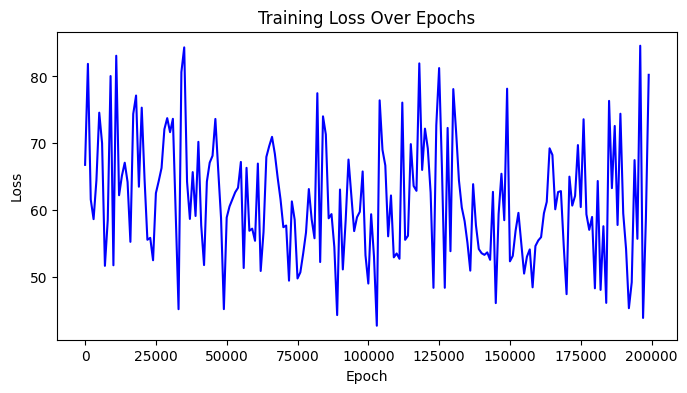

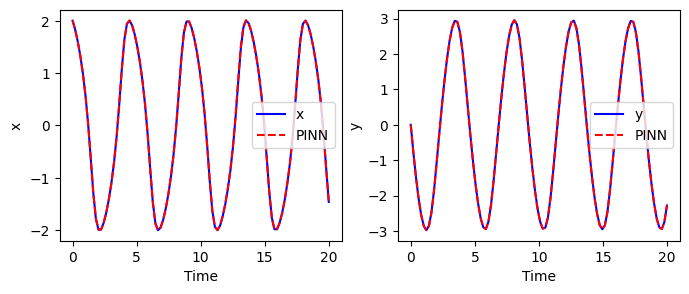

In [8]:
if __name__=='__main__':

    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values = []
    epoch_num = 200000
    for epoch in range(epoch_num):

        loss = loss_func(model, t_tensor, x_real_tensor, y_real_tensor, y0[0], y0[1], epsilon, random_points=10)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 5000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_values.append(loss.item())
        
    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b-')  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()



    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(t_tensor).numpy().T
    
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, x_real, 'b-', label='x')
    plt.plot(t, x_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(t, y_real, 'b-', label='y')
    plt.plot(t, y_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

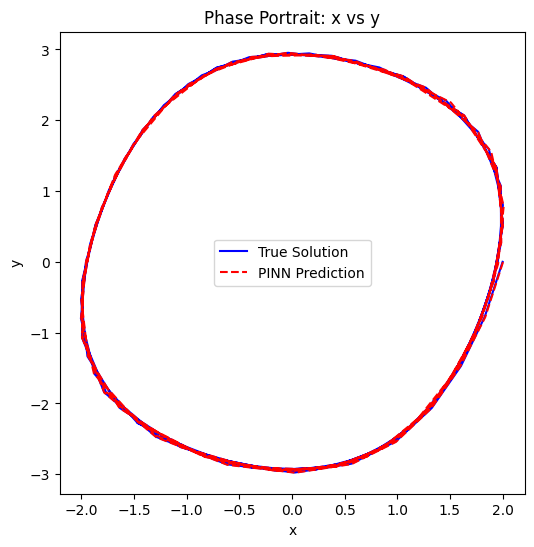

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(x_real, y_real, 'b-', label='True Solution')
plt.plot(x_pred, y_pred, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait: x vs y')
plt.legend()
plt.show()